<a href="https://colab.research.google.com/github/Ishmeet7/Ishme_DS_242EX/blob/main/Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and Importing packages

In [ ]:
import pandas as pd #importing libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy import radians, cos, sin, arcsin, sqrt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive   #mount drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading data

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Data/BMTC.parquet.gzip', engine='pyarrow') # This command loads BMTC data into a dataframe. 
                                                                      # In case of error, install pyarrow using: 
                                                                      # pip install pyarrow
dfInput = pd.read_csv('/content/drive/MyDrive/Data/Input.csv')
dfGroundTruth = pd.read_csv('/content/drive/MyDrive/Data/GroundTruth.csv')

In [ ]:
#df = df[(df['Latitude']>12.95)&(df['Latitude']<=13.00)&(df['Longitude']>77.55)&(df['Longitude']<=77.60)]


# Exploratory Data Analysis

In [ ]:
g1=df.groupby('BusID') #grouping data using BusID
unique=df.BusID.unique()

# Preprocessing

In [ ]:
def pre_processing(df):
  d1 = df.drop_duplicates(subset=['Latitude','Longitude','Speed'],keep=("first"),inplace=False) #If the consecutive rows have same latitude,longitude and speed values keeping only first and last row
  d2 = df.drop_duplicates(subset=['Latitude','Longitude','Speed'],keep=("last"),inplace=False)
  d3 = pd.concat([d1,d2]).drop_duplicates()
  return d3

In [ ]:
pre_processing(df)

,BusID,Latitude,Longitude,Speed,Timestamp
0,150212121,13.074558,77.445549,0.0,2019-08-01 07:00:02
152,150212121,13.074558,77.445549,9.0,2019-08-01 07:25:16
153,150212121,13.074113,77.445282,21.0,2019-08-01 07:25:26
154,150212121,13.074060,77.445267,0.0,2019-08-01 07:25:36
173,150212121,13.074060,77.445267,13.0,2019-08-01 07:28:45
...,...,...,...,...,...
6014786,150813395,13.099629,77.596695,0.0,2019-08-01 18:33:36
6014803,150813395,13.099418,77.596924,0.0,2019-08-01 18:36:26
6014823,150813395,13.099084,77.597076,0.0,2019-08-01 18:39:44
6014852,150813395,13.095264,77.594536,0.0,2019-08-01 18:44:33


## Creating a Subset of Data Based on similar route

105


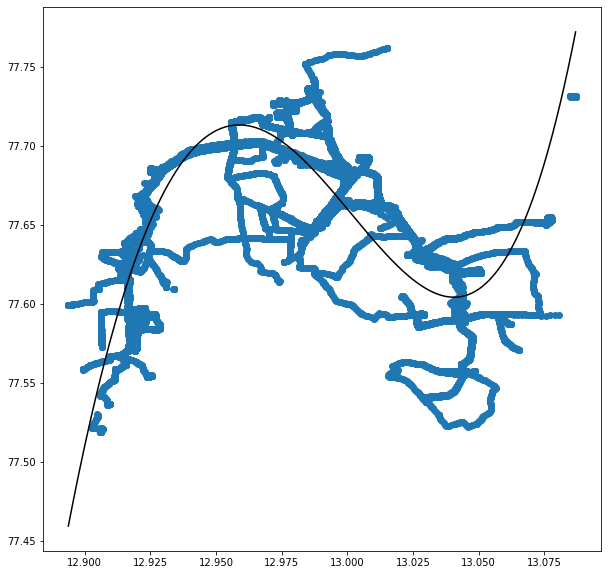

In [ ]:
g = df.groupby('BusID')

bus1 = g.get_group(150218010)
bus2 = g.get_group(150813389)

bus1.reset_index(inplace = True, drop = True)
bus2.reset_index(inplace = True, drop = True)

buses = pd.concat([bus1,bus2],axis=0)

lat = np.array(buses['Latitude']).reshape(-1, 1)
poly_feature = PolynomialFeatures(4)#degree is 4
x_poly = poly_feature.fit_transform(lat)#fit data and then transform
reg = LinearRegression()
reg.fit(x_poly, buses['Longitude'])#fit linear model
y_predict = reg.predict(x_poly)#prediction using model
rmse = (mse(buses['Longitude'], y_predict)) ** 0.5  #rmse calculation

count = 0
cluster = pd.DataFrame()
for i in g.size().index:
    bus = g.get_group(i)
    bus.reset_index(inplace = True, drop = True)
    lat = np.array(bus['Latitude']).reshape(-1, 1)
    x_poly = poly_feature.fit_transform(lat)
    y_predict = reg.predict(x_poly)#prediction using model
    rmse = (mse(bus['Longitude'], y_predict)) ** 0.5  #rmse calculation
    if rmse <= 0.03:
        count+=1
        cluster = pd.concat([cluster,bus], axis=0)
        
print(count)


plt.figure(figsize=(10,10))
plt.scatter(cluster['Latitude'], cluster['Longitude'])
xp = np.linspace(cluster['Latitude'].min(), cluster['Latitude'].max(), 1000).reshape(-1, 1)#2923 is len of train data
x_poly = poly_feature.fit_transform(xp)
y_predict = reg.predict(x_poly)
plt.plot(xp,y_predict,color='k')

# Feature Extraction

In [ ]:
#calculating Haversine distance between two points on earth
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """

    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1.values)
    lat1 = np.radians(lat1.values)
    lon2 = np.radians(lon2.values)
    lat2 = np.radians(lat2.values)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),  
                          np.multiply(np.cos(lat1), 
                                      np.multiply(np.cos(lat2), 
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))
    c = np.multiply(2, np.arcsin(np.sqrt(a)))
    r = 6371
    
    return c*r

In [ ]:
d3 = cluster
d4=d3.loc[:,["Latitude",'Longitude']]
d7=d3.shift(1)             #creating a lag of p=1
d5=d4.shift(periods=1, freq=None, axis=0)

d5.rename(columns = {'Latitude':'Source_Lat', 'Longitude':'Source_Long'}, inplace = True) #concatenating shifted dataframe to original dataframe and renaming columns
d4.rename(columns = {'Latitude':'Dest_Lat', 'Longitude':'Dest_Long'}, inplace = True)
d6=pd.concat([d5,d4], axis=1)

distance=haversine(d4['Dest_Long'],d4['Dest_Lat'],d5['Source_Long'],d5['Source_Lat'])

time=d3['Timestamp']-d7['Timestamp'] #calculating time required to travel distance between two consecutive rows of latitude and logitude

time=time.apply(lambda x: x.seconds/60)

d6['Distance']=distance   #adding new columns to dataframe
d6['Duration']=time

In [ ]:
d6.columns

Index(['Source_Lat', 'Source_Long', 'Dest_Lat', 'Dest_Long', 'Distance',
       'Duration'],
      dtype='object')

In [ ]:
d6.head() #created dataframe

,Source_Lat,Source_Long,Dest_Lat,Dest_Long,Distance,Duration
0,NaN,NaN,13.043344,77.609070,NaN,NaN
1,13.043344,77.609070,13.043061,77.610191,0.125445,0.166667
2,13.043061,77.610191,13.042920,77.611275,0.118468,0.166667
3,13.042920,77.611275,13.042670,77.612312,0.115723,0.166667
4,13.042670,77.612312,13.042445,77.613235,0.103068,0.166667


In [ ]:
d6.replace([np.inf, -np.inf], np.nan, inplace=True)    #replacing very large values with Nan
d6.drop(d6.tail(1).index, #dropping the first and last rows from dataframe
        inplace = True)
d6.drop(d6.head(1).index,
        inplace = True)

pd.set_option('mode.use_inf_as_na', True)
d6.dropna(how='any', inplace=True)       #dropping rows with Nan values from new dataframe
# check = d6[d6.isna().any(axis=1)]

# d6.drop(['Duration'],axis=1)

In [ ]:
d6

,Source_Lat,Source_Long,Dest_Lat,Dest_Long,Distance,Duration
1,13.043344,77.609070,13.043061,77.610191,0.125445,0.166667
2,13.043061,77.610191,13.042920,77.611275,0.118468,0.166667
3,13.042920,77.611275,13.042670,77.612312,0.115723,0.166667
4,13.042670,77.612312,13.042445,77.613235,0.103068,0.166667
5,13.042445,77.613235,13.042300,77.613518,0.034638,0.166667
...,...,...,...,...,...,...
3441,12.916583,77.572472,12.916560,77.572182,0.031534,0.166667
3442,12.916560,77.572182,12.916540,77.572044,0.015121,0.166667
3443,12.916540,77.572044,12.916533,77.571754,0.031440,0.166667
3444,12.916533,77.571754,12.916572,77.571442,0.034092,0.166667


In [ ]:
X_train=d6.drop(['Duration'],axis=1) #creating training dataset 
#dropping Duration attribute

In [ ]:
X_train

,Source_Lat,Source_Long,Dest_Lat,Dest_Long,Distance
1,13.043344,77.609070,13.043061,77.610191,0.125445
2,13.043061,77.610191,13.042920,77.611275,0.118468
3,13.042920,77.611275,13.042670,77.612312,0.115723
4,13.042670,77.612312,13.042445,77.613235,0.103068
5,13.042445,77.613235,13.042300,77.613518,0.034638
...,...,...,...,...,...
3441,12.916583,77.572472,12.916560,77.572182,0.031534
3442,12.916560,77.572182,12.916540,77.572044,0.015121
3443,12.916540,77.572044,12.916533,77.571754,0.031440
3444,12.916533,77.571754,12.916572,77.571442,0.034092


In [ ]:
y_train=d6['Duration']  #creating target variable

In [ ]:
y_train

1       0.166667
2       0.166667
3       0.166667
4       0.166667
5       0.166667
          ...   
3441    0.166667
3442    0.166667
3443    0.166667
3444    0.166667
3445    0.166667
Name: Duration, Length: 329871, dtype: float64

In [ ]:
d6.to_parquet('data.parquet.gzip',engine='pyarrow',compression='gzip')

In [ ]:
# d6[d6['Duration']>=720]
# len(d6[d6['Distance']>=30])
out = pd.cut(d6['Distance'], bins=[-0.1, 0, 0.05, 0.1, 0.2, 0.4, 1, 2, 5, 10, 20, 40, 50], include_lowest=True)
out1 = pd.cut(d6['Duration'], bins=[-0.1, 0, 0.1, 0.5, 1, 4, 10, 20, 50, 90, 180, 300, 500, 800, 1200, 1500], include_lowest=True)
out1.value_counts()

(0.1, 0.5]          325600
(0.5, 1.0]            1565
(0.0, 0.1]            1474
(10.0, 20.0]           665
(1.0, 4.0]             368
(20.0, 50.0]           128
(4.0, 10.0]             29
(-0.101, 0.0]           23
(50.0, 90.0]            14
(180.0, 300.0]           3
(90.0, 180.0]            1
(300.0, 500.0]           1
(500.0, 800.0]           0
(800.0, 1200.0]          0
(1200.0, 1500.0]         0
Name: Duration, dtype: int64

In [ ]:
out.value_counts()

(-0.101, 0.0]    128304
(0.0, 0.05]      113786
(0.05, 0.1]       50896
(0.1, 0.2]        34734
(0.2, 0.4]         1086
(0.4, 1.0]          558
(2.0, 5.0]          259
(1.0, 2.0]          134
(5.0, 10.0]         114
(10.0, 20.0]          0
(20.0, 40.0]          0
(40.0, 50.0]          0
Name: Distance, dtype: int64

In [ ]:
test_df=dfInput

distance1=haversine(test_df['Dest_Long'],test_df['Dest_Lat'],test_df['Source_Long'],test_df['Source_Lat'])

test_df['Distance']=distance1         #creating distance attribute in testing csv

# test_df.drop("Unnamed: 0",axis=1,inplace=True) #dropping extra column from testing csv
print(test_df.columns)

X_test=test_df

Index(['Source_Lat', 'Source_Long', 'Dest_Lat', 'Dest_Long', 'Distance'], dtype='object')


In [ ]:
X_test.replace([np.inf, -np.inf], np.nan, inplace=True) #replacing very large values with Nan


In [ ]:
#checking for Nan value of distance in testing csv
X = X_test['Distance'].isna()
c=0
for i in X:
  if i :
    print(X_test[c])
  c+=1
print(c)


1205


In [ ]:
y_test=dfGroundTruth
print(y_test.columns)
# y_test.drop("Unnamed: 0",axis=1,inplace=True)

Index(['Unnamed: 0', 'TT'], dtype='object')


In [ ]:
y_test=y_test['TT']
# X_test.drop('TT',axis=1)

In [ ]:
test=pd.concat([X_test,y_test], axis=1)  
# X_test.dropna(how='any', inplace=True) #dropping  rows containing Nan values from dataset

# Linear Regression Model

In [ ]:
reg_model=LinearRegression() 
reg_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
test = test[(test['Source_Lat']>12.95)&(test['Source_Lat']<=13.00)&(test['Source_Long']>77.55)&(test['Source_Long']<=77.60)]

In [ ]:
test.columns

Index(['Source_Lat', 'Source_Long', 'Dest_Lat', 'Dest_Long', 'Distance', 'TT'], dtype='object')

In [ ]:
y_test=test['TT']

In [ ]:
test.drop("TT",axis=1,inplace=True)

In [ ]:
print(reg_model.score(test, y_test))

0.48984796937147557


# Random Forest Model

In [ ]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X_train,y_train, train_size = 0.006, random_state=42) 

In [ ]:
forest_model = RandomForestRegressor(random_state=1,oob_score=True,)
forest_model.fit(Xtrain,ytrain)
#print("yes")

RandomForestRegressor(oob_score=True, random_state=1)

In [ ]:
pred = forest_model.predict(X_test)
print("Mean absolute error obtained is:",mean_absolute_error(y_test, pred))

Mean absolute error obtained is: 136.21600995850625


In [ ]:
#dfInput['ETT']=pred

In [ ]:
#dfInput

In [ ]:
dfGroundTruth

,Unnamed: 0,TT
0,0,2.833333
1,1,1.500000
2,2,21.250000
3,3,2.000000
4,4,35.733333
...,...,...
1200,1200,27.233333
1201,1201,26.750000
1202,1202,53.600000
1203,1203,59.616667


# For Evaluation
function for evauation
  2. Function arguments:
    
    a. df: It is a pandas dataframe that contains the data from BMTC.parquet.gzip
   
    b. dfInput: It is a pandas dataframe that contains the input from Input.csv

3. Returns:

    a. dfOutput: It is a pandas dataframe that contains the output


In [ ]:
def EstimatedTravelTime(df, dfInput): # The output of this function will be evaluated
    # Function body - Begins
    # Make changes here.  
                              
    dfOutput = pd.DataFrame()


    # Function body - Ends
    return dfOutput

In [ ]:
dfOutput = EstimatedTravelTime(df, dfInput)

# AutoML

In [ ]:
#!apt install -y build-essential swig curl

In [ ]:
# !pip install auto-sklearn

In [ ]:
# Install packages
# !curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
# !pip install auto-sklearn

In [ ]:
# from autosklearn.regression import AutoSklearnRegressor
# # Create the AutoSklearnRegessor
# sklearn = AutoSklearnRegressor(time_left_for_this_task=360,per_run_time_limit=30,memory_limit=5000,n_jobs=-1)
# # Fit the training data
# sklearn.fit(Xtrain, ytrain)
# # Sprint Statistics
# print(sklearn.sprint_statistics())
# # Predict the validation data
# pred_sklearn = sklearn.predict(X_test)
# # Compute the RMSE
# rmse_sklearn=MSE(y_test, pred_sklearn)**0.5
# print('RMSE: ' + str(rmse_sklearn))

In [ ]:
# sklearn.get_models_with_weights()

In [ ]:
# sklearn.leaderboard()

In [ ]:
# from autosklearn.regression import AutoSklearnRegressor
# # Create the AutoSklearnRegessor
# sklearn = AutoSklearnRegressor(time_left_for_this_task=360,per_run_time_limit=45,memory_limit=5500,n_jobs=-1)
# # Fit the training data
# sklearn.fit(Xtrain, ytrain)
# # Sprint Statistics
# print(sklearn.sprint_statistics())
# # Predict the validation data
# pred_sklearn = sklearn.predict(X_test)
# # Compute the RMSE
# rmse_sklearn=MSE(y_test, pred_sklearn)**0.5
# print('RMSE: ' + str(rmse_sklearn))

In [ ]:
# sklearn.leaderboard()

In [ ]:
# from autosklearn.regression import AutoSklearnRegressor
# # Create the AutoSklearnRegessor
# sklearn = AutoSklearnRegressor(time_left_for_this_task=36000,per_run_time_limit=3600,memory_limit=5000,n_jobs=-1)
# # Fit the training data
# sklearn.fit(Xtrain, ytrain)
# # Sprint Statistics
# print(sklearn.sprint_statistics())
# # Predict the validation data
# pred_sklearn = sklearn.predict(X_test)
# # Compute the RMSE
# rmse_sklearn=MSE(y_test, pred_sklearn)**0.5
# print('RMSE: ' + str(rmse_sklearn))

In [ ]:
# import matplotlib.pyplot as plt 
# # Scatter plot true and predicted values
# plt.scatter(pred_sklearn, y_val, alpha=0.2)
# plt.xlabel('predicted')
# plt.ylabel('true value')